### Libraries

In [1]:
import matplotlib
import tools as t
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import spatial
from mpl_toolkits.mplot3d import Axes3D

sns.set_style('darkgrid')
%matplotlib inline

### Hyperparameters

In [2]:
k = 2 
l = 3
n_verts = 500
dist_thrshld = 1

### Create Affinity Matrix

Text(0.5, 1.0, 'Distance Distribution')

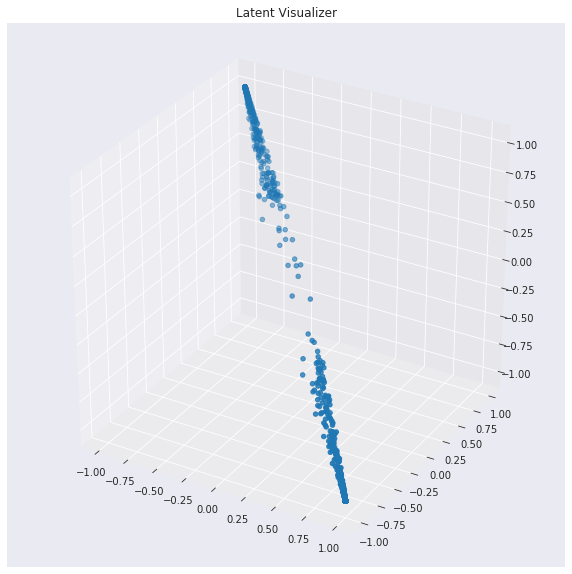

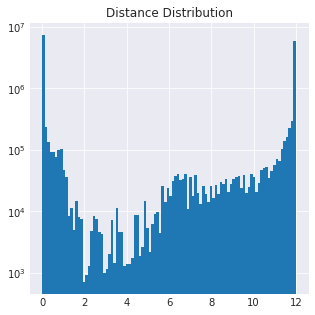

In [3]:
'''Choose points from specific layer and epoch'''
data = np.load('/home/zz452/cluster/data/modelTishby_0_layer_data.p')
layer = data[-2] 
n_epochs, n_sample, n_dim = layer.shape
points = layer[83,:,:]

M_d = spatial.distance_matrix(points,
                              points,
                              p=2)**2
mask = M_d<dist_thrshld
remove_diag = np.eye(n_sample)==0
mask = remove_diag*mask

stay_prob = np.eye(n_sample)*0.5
d = mask.sum(0).max()
move_prob = 1/(2*d)

M = move_prob*mask + stay_prob
add_self_loop = np.diag(1-M.sum(0))
M = M + add_self_loop
M = M.astype('float32')

'''Visualize'''
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0],
           points[:,1], 
           points[:,2])
ax.title.set_text('Latent Visualizer')

fig = plt.figure(figsize=(5, 5))
plt.hist(M_d.flatten(), log=True, bins=100)
plt.title('Distance Distribution')

### Random Sample of Vertices

In [4]:
# create a mask so that we dont sample verteces that are not connected to anything 
singles_mask = mask.sum(0)>0
singles_mask = singles_mask.reshape(-1,1)

#total number of vertices that are connected (not to itself)
n = (mask.sum(0) > 0).sum() 

S = np.random.random_sample((M.shape[1], 
                             n_verts))
S = S*singles_mask
S = (S.max(axis=0,keepdims=1) == S)*1
S = S.astype('float32')

### Random Walk

In [5]:
M_l = np.linalg.matrix_power(M, l)
S_l = np.matmul(M_l, S)
p_l2 = np.linalg.norm(S_l, ord=2, axis=0)**2
sigma = 192*n_verts*k/n
keep_idx = p_l2<sigma

'''
TODO: put a function that sample more vertices if it doesnt pass the sigma test'
【・ヘ・】
'''
assert len(keep_idx)==n_verts, 'Sample more vertices, didnt pass sigma test'

### Similarlity Graph

In [6]:
H = spatial.distance_matrix(np.swapaxes(S_l,0,1),
                            np.swapaxes(S_l,0,1),
                            p=2)**2
remove_diag = np.eye(n_verts)*9999
H = H+remove_diag
H = H<=1/(4*n)

g = t.Graph(120, 120, H) 

print('{} islands'.format(g.countIslands()))
if g.countIslands()>k:
    print('Need more clustering （・∩・)')
else:
    print('Good amount of clustering (･o･)')

8 islands
Need more clustering （・∩・)
